# IMPORT ESSENTIAL PYTHON LIBRARIES

In [1]:
# Basic Libraries
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt # we only need pyplot
sb.set() # set the default Seaborn style for graphics

In [2]:
# Import essential models and functions from sklearn
from sklearn.tree import DecisionTreeClassifier # Decision Tree Classifier model from Scikit-Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix # to plot the two-way Confusion Matrix
from sklearn.tree import plot_tree # to plot the trained Decision Tree

In [3]:
# Import the encoder from sklearn
from sklearn.preprocessing import OneHotEncoder
ohe = OneHotEncoder()

# IMPORT THE DATASET

We will use the data stored in `cleaned-alzheimers-dataset.csv` created at the end of `Data Extraction and Cleaning`

In [4]:
alzheimersData = pd.read_csv('cleaned-alzheimers-dataset.csv',index_col= 0)
alzheimersData

,MRI ID,M/F,Age,Educ,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS1_0001_MR1,F,74,2.0,3.0,29.0,0.0,1344,0.743,1.306
1,OAS1_0002_MR1,F,55,4.0,1.0,29.0,0.0,1147,0.810,1.531
2,OAS1_0003_MR1,F,73,4.0,3.0,27.0,0.5,1454,0.708,1.207
3,OAS1_0010_MR1,M,74,5.0,2.0,30.0,0.0,1636,0.689,1.073
4,OAS1_0011_MR1,F,52,3.0,2.0,30.0,0.0,1321,0.827,1.329
...,...,...,...,...,...,...,...,...,...,...
603,OAS2_0185_MR2,M,82,1.0,1.0,28.0,0.5,1693,0.694,1.037
604,OAS2_0185_MR3,M,86,1.0,1.0,26.0,0.5,1688,0.675,1.040
605,OAS2_0186_MR1,F,61,1.0,2.0,30.0,0.0,1319,0.801,1.331
606,OAS2_0186_MR2,F,63,1.0,2.0,30.0,0.0,1327,0.796,1.323


# CREATING A MODEL FOR `CDR`: Attempt 1

## Encode Categorical Variables

`DecisionTreeClassifier` in `sklearn` does not handle categorical variables directly as a part of the current implementation. Thus, there is a need to encode the levels of a categorical variable as integers. For categorical variables which may not be *ordinal*, `OneHotEncoding` from `sklearn` preprocessing module will be used.

TO CHECK: `Educ`and `SES`are already encoded as integers in the cleaned dataset. `M/F` - Gender is not ordinal. Hence, it should be encoded by `OneHotEncoding` 

In [5]:
# OneHotEncoding of categorical predictors (not the response)
alzheimersData_gender = alzheimersData[['M/F']]
ohe.fit(alzheimersData_gender)
alzheimersData_gender_ohe = pd.DataFrame(ohe.transform(alzheimersData_gender).toarray(), 
                                  columns=ohe.get_feature_names_out(alzheimersData_gender.columns))

# Check the encoded variables
alzheimersData_gender.info()

<class 'pandas.core.frame.DataFrame'>
Index: 608 entries, 0 to 607
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   M/F     608 non-null    object
dtypes: object(1)
memory usage: 9.5+ KB


In [6]:
# Assuming alzheimersData_gender_ohe is one-hot encoded gender features
alzheimersData_num = alzheimersData[['Age', 'MMSE']]
alzheimersData_cat = alzheimersData[['Educ', 'SES']]
alzheimersData_response = alzheimersData['CDR']

# Perform One-Hot Encoding on categorical features
alzheimersData_cat_ohe = pd.get_dummies(alzheimersData_cat)

# Concatenate numeric features, one-hot encoded categorical features, and response variable
alzheimersData_ohe = pd.concat([alzheimersData_num, alzheimersData_cat_ohe, alzheimersData_response], axis=1)

# Check the final dataframe
alzheimersData_ohe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 608 entries, 0 to 607
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Age     608 non-null    int64  
 1   MMSE    606 non-null    float64
 2   Educ    608 non-null    float64
 3   SES     570 non-null    float64
 4   CDR     608 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 28.5 KB


## Create and Fit the Model

To ensure that 'CDR' is treated as a categorical variable representing the different classes ('Normal', 'Very Mild', 'Mild', 'Moderate'), explicitly convert it to the categorical data type using pd.Categorical().

In [68]:
alzheimersData_ohe['CDR'] = pd.Categorical(alzheimersData_ohe['CDR'], categories=[0, 0.5, 1, 2], ordered=True).codes.astype(int)
print(alzheimersData_ohe['CDR'].unique())

[ 0 -1]


Finally, after the encoding is done, we can create and fit the `DecisionTreeClassifier` model on the dataset.

In [69]:
# Extract Response and Predictors
y = pd.DataFrame(alzheimersData_ohe['CDR']) #Response
x = pd.DataFrame(alzheimersData_ohe.drop('CDR', axis = 1)) #Predictors

A simple Python function can be written and called

In [70]:
def ClassificationTree(predictor, response, depth):
    
    # Split the Legendary-Total Dataset into Train and Test
    X_train, X_test, y_train, y_test = train_test_split(predictor, response, test_size=0.25, random_state=25)
    
    # Decision Tree using Train Data
    dectree = DecisionTreeClassifier(max_depth = depth)
    dectree.fit(X_train, y_train)
    
    # Predict Response values corresponding to Predictor
    y_train_pred = dectree.predict(X_train)
    y_test_pred = dectree.predict(X_test)
    
    
    # Plot the trained Decision Tree
    f = plt.figure(figsize=(12,12))
    plot_tree(dectree, filled=True, rounded=True, 
          feature_names= X_train.columns.tolist(), # Convert Index object to list
          class_names=['Normal','Very Mild','Mild', 'Moderate', 'Severe']) 
    
    return X_train, X_test, y_train, y_test, y_train_pred, y_test_pred, dectree

### Classification Tree Model of Max Depth 3

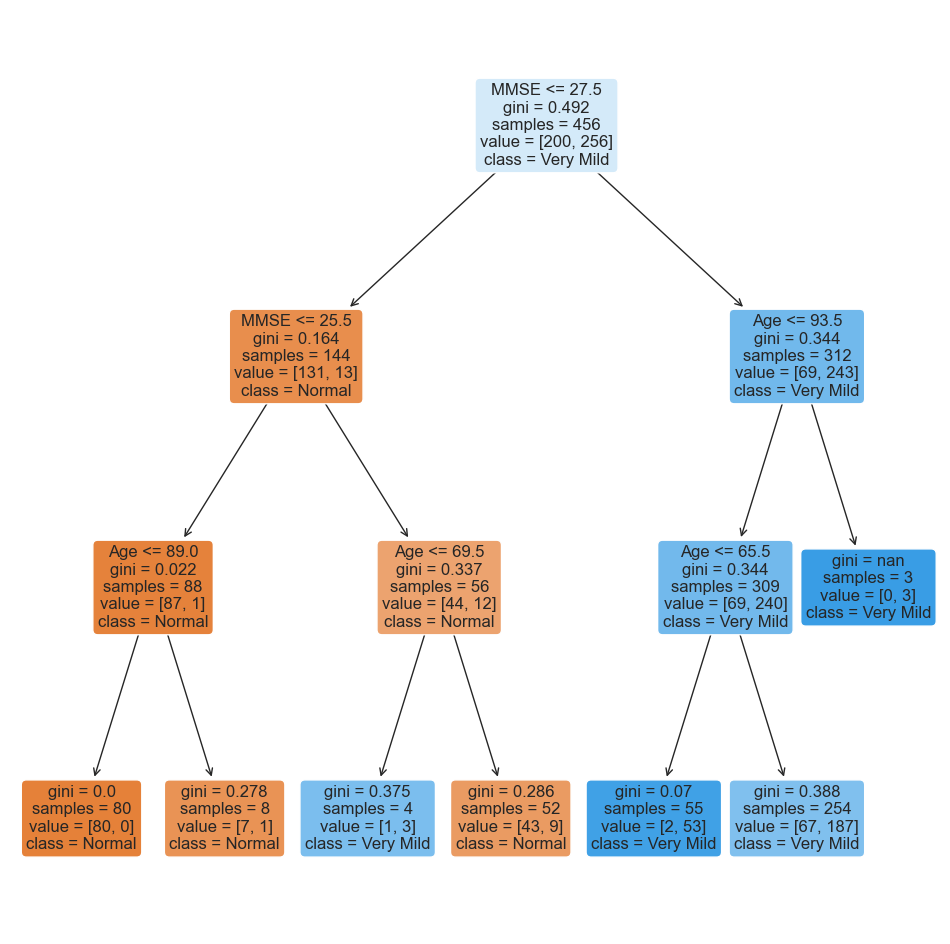

In [71]:
X_train3, X_test3, y_train3, y_test3, y_train_pred3, y_test_pred3, dectree3 = ClassificationTree(x, y, 3)

### Classification Tree Model of Max Depth 4

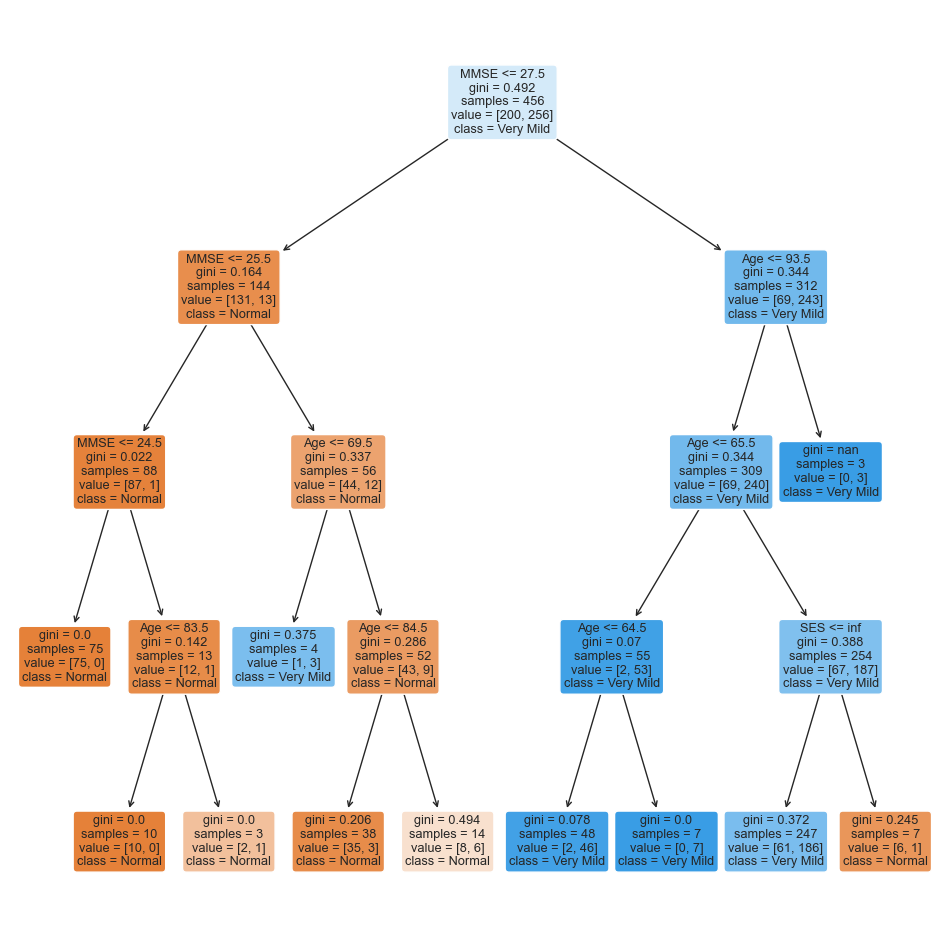

In [72]:
X_train4, X_test4, y_train4, y_test4, y_train_pred4, y_test_pred4, dectree4 = ClassificationTree (x, y, 4)

## Check the Accuracy of the Model

### Check the accuracy of the Model

Print the Classification Accuracy and all other Accuracy Measures from the Confusion Matrix.  

| Confusion Matrix  |       |        |        |      
| :---              | :---: | :----: | :----: |         
| Actual Negative   |  (0)  |   TN   |   FP   |             
| Actual Positive   |  (1)  |   FN   |   TP   |       
|                   |       |   (0)   |   (1)   |       
|                   |       | Predicted Negative    |   Predicted Postitive  |     


* `TPR = TP / (TP + FN)` : True Positive Rate = True Positives / All Positives    
* `TNR = TN / (TN + FP)` : True Negative Rate = True Negatives / All Negatives    

* `FPR = FP / (TN + FP)` : False Positive Rate = False Positives / All Negatives 
* `FNR = FN / (TP + FN)` : False Negative Rate = False Negatives / All Positives 

Again, a simple Python function can be written and called

In [73]:
def confusionmatrixValues(confusionmatrix):
    tn = confusionmatrix[0][0]
    fp = confusionmatrix[0][1]
    fn = confusionmatrix[1][0]
    tp = confusionmatrix[1][1]

    return tn, fp, fn, tp

def printConfusionMatrix(X_train, X_test, y_train, y_test, y_train_pred, y_test_pred , dectree):
    
    confusionmatrix_train = confusion_matrix(y_train, y_train_pred)
    confusionmatrix_test = confusion_matrix(y_test, y_test_pred)

    # Plot the Confusion Matrix for Train and Test
    f, axes = plt.subplots(1, 2, figsize=(12, 4))
    sb.heatmap(confusionmatrix_train,
            annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[0])
    sb.heatmap(confusionmatrix_test, 
            annot = True, fmt=".0f", annot_kws={"size": 18}, ax = axes[1])


    tn_train, fp_train, fn_train, tp_train = confusionmatrixValues(confusionmatrix_train)
    tn_test, fp_test, fn_test, tp_test = confusionmatrixValues(confusionmatrix_test)
    

    # Check the Goodness of Fit (on Train Data)
    print("Goodness of Fit of Model \tTrain Dataset")
    print("Classification Accuracy \t:", dectree.score(X_train, y_train))
    print("True Positive Rate (TPR) \t:", tp_train / (tp_train + fn_train))
    print("True Negative Rate (TNR) \t:", tn_train / (tn_train + fp_train))
    print()
    print("False Positive Rate (FPR) \t:", fp_train / (fp_train + tn_train))
    print("False Negative Rate (FNR) \t:", fn_train / (tp_train + fn_train))
    print()

    # Check the Goodness of Fit (on Test Data)
    print("Goodness of Fit of Model \tTest Dataset")
    print("Classification Accuracy \t:", dectree.score(X_test, y_test))
    print("True Positive Rate (TPR) \t:", tp_train / (tp_train + fn_train))
    print("True Negative Rate (TNR) \t:", tn_train / (tn_train + fp_train))
    print()
    print("False Positive Rate (FPR) \t:", fp_train / (fp_train + tn_train))
    print("False Negative Rate (FNR) \t:", fn_train / (tp_train + fn_train))
    print()
    
    print()

    return

### Confusion Matrix for Classification Tree Model of Max Depth 3

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.8245614035087719
True Positive Rate (TPR) 	: 0.9609375
True Negative Rate (TNR) 	: 0.65

False Positive Rate (FPR) 	: 0.35
False Negative Rate (FNR) 	: 0.0390625

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.868421052631579
True Positive Rate (TPR) 	: 0.9609375
True Negative Rate (TNR) 	: 0.65

False Positive Rate (FPR) 	: 0.35
False Negative Rate (FNR) 	: 0.0390625




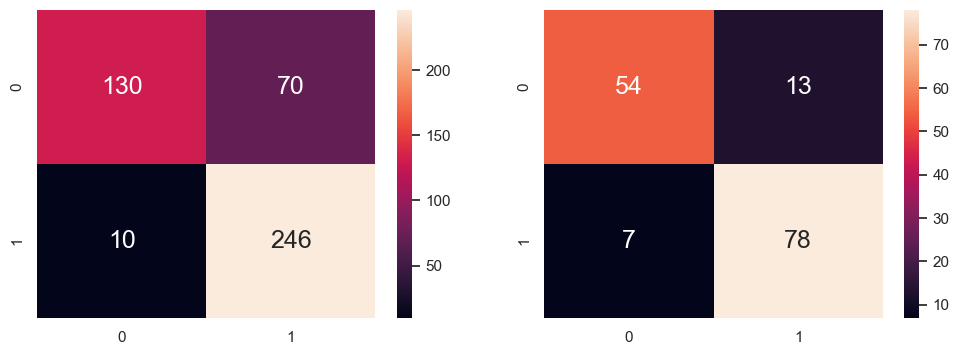

In [74]:
printConfusionMatrix(X_train3, X_test3, y_train3, y_test3, y_train_pred3, y_test_pred3, dectree3)

### Confusion Matrix for Classification Tree Model of Max Depth 4

Goodness of Fit of Model 	Train Dataset
Classification Accuracy 	: 0.8355263157894737
True Positive Rate (TPR) 	: 0.95703125
True Negative Rate (TNR) 	: 0.68

False Positive Rate (FPR) 	: 0.32
False Negative Rate (FNR) 	: 0.04296875

Goodness of Fit of Model 	Test Dataset
Classification Accuracy 	: 0.881578947368421
True Positive Rate (TPR) 	: 0.95703125
True Negative Rate (TNR) 	: 0.68

False Positive Rate (FPR) 	: 0.32
False Negative Rate (FNR) 	: 0.04296875




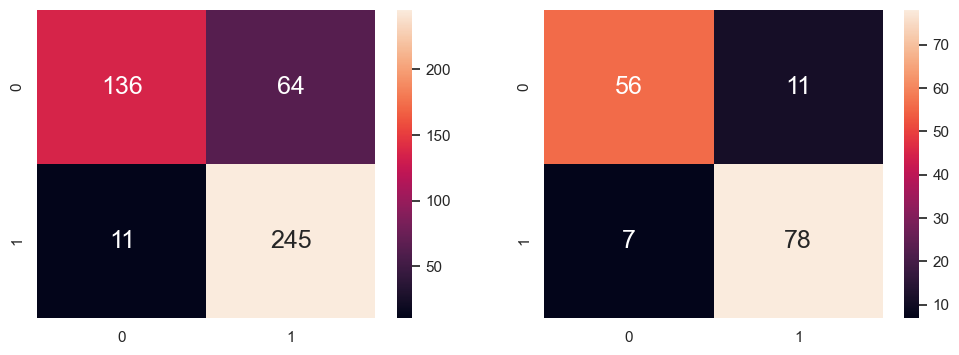

In [75]:
printConfusionMatrix(X_train4, X_test4, y_train4, y_test4, y_train_pred4, y_test_pred4, dectree4)

---

# CREATING A MODEL FOR `CDR`: Attempt 2

Refine the previous model by balancing the classes of the response `CDR` in the training data. Keeping the OneHotEncoding same as before.

In [77]:
from sklearn.utils import resample
import warnings

# Identify the different classes and their counts in the 'CDR' column
cdr_value_counts = alzheimersData['CDR'].value_counts()

# Find the majority class and its count
majority_class = cdr_value_counts.idxmax()
majority_class_count = cdr_value_counts.max()

# Split the dataset into subsets based on the value of the 'CDR' variable
subsets = {cdr_value: alzheimersData[alzheimersData['CDR'] == cdr_value] for cdr_value in cdr_value_counts.index}

# Upsample minority classes
upsampled_subsets = [subsets[majority_class]]  # start with the majority class

for cdr_value, subset in subsets.items():
    if cdr_value != majority_class:  # only upsample minority classes
        upsampled_subset = resample(subset,
                                    replace=True,
                                    n_samples=majority_class_count,  # match number in majority class
                                    random_state=42)  # reproducible results
        upsampled_subsets.append(upsampled_subset)

# Combine the upsampled classes with the majority class to form a balanced dataset
balanced_alzheimers_data = pd.concat(upsampled_subsets)

# Check the new value counts to ensure the classes are balanced
balanced_value_counts = balanced_alzheimers_data['CDR'].value_counts()
balanced_value_counts

CDR
0.0    341
0.5    341
1.0    341
2.0    341
Name: count, dtype: int64

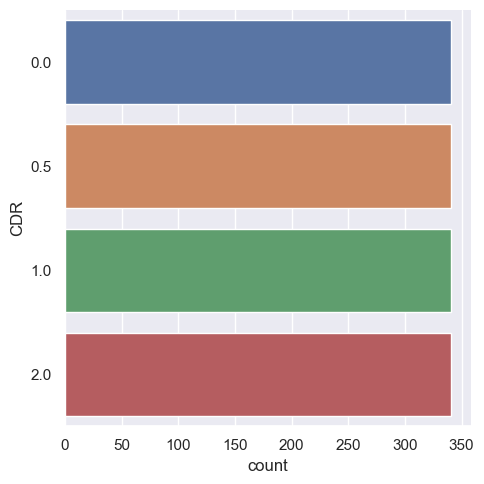

In [78]:
warnings.filterwarnings('ignore', message='The figure layout has changed to tight')

# Quick plot to check the balanced classes visually
sb.catplot(y = 'CDR', data = balanced_alzheimers_data, kind = "count")

In [79]:
# Confirm that the OHE is still in place
# and that the samples have now increased
balanced_alzheimers_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1364 entries, 0 to 159
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   MRI ID  1364 non-null   object 
 1   M/F     1364 non-null   object 
 2   Age     1364 non-null   int64  
 3   Educ    1364 non-null   float64
 4   SES     1272 non-null   float64
 5   MMSE    1357 non-null   float64
 6   CDR     1364 non-null   float64
 7   eTIV    1364 non-null   int64  
 8   nWBV    1364 non-null   float64
 9   ASF     1364 non-null   float64
dtypes: float64(6), int64(2), object(2)
memory usage: 117.2+ KB


### Create and Fit the Model

After the encoding and upsampling is done, we can create and fit the `DecisionTreeClassifier` model on the dataset.

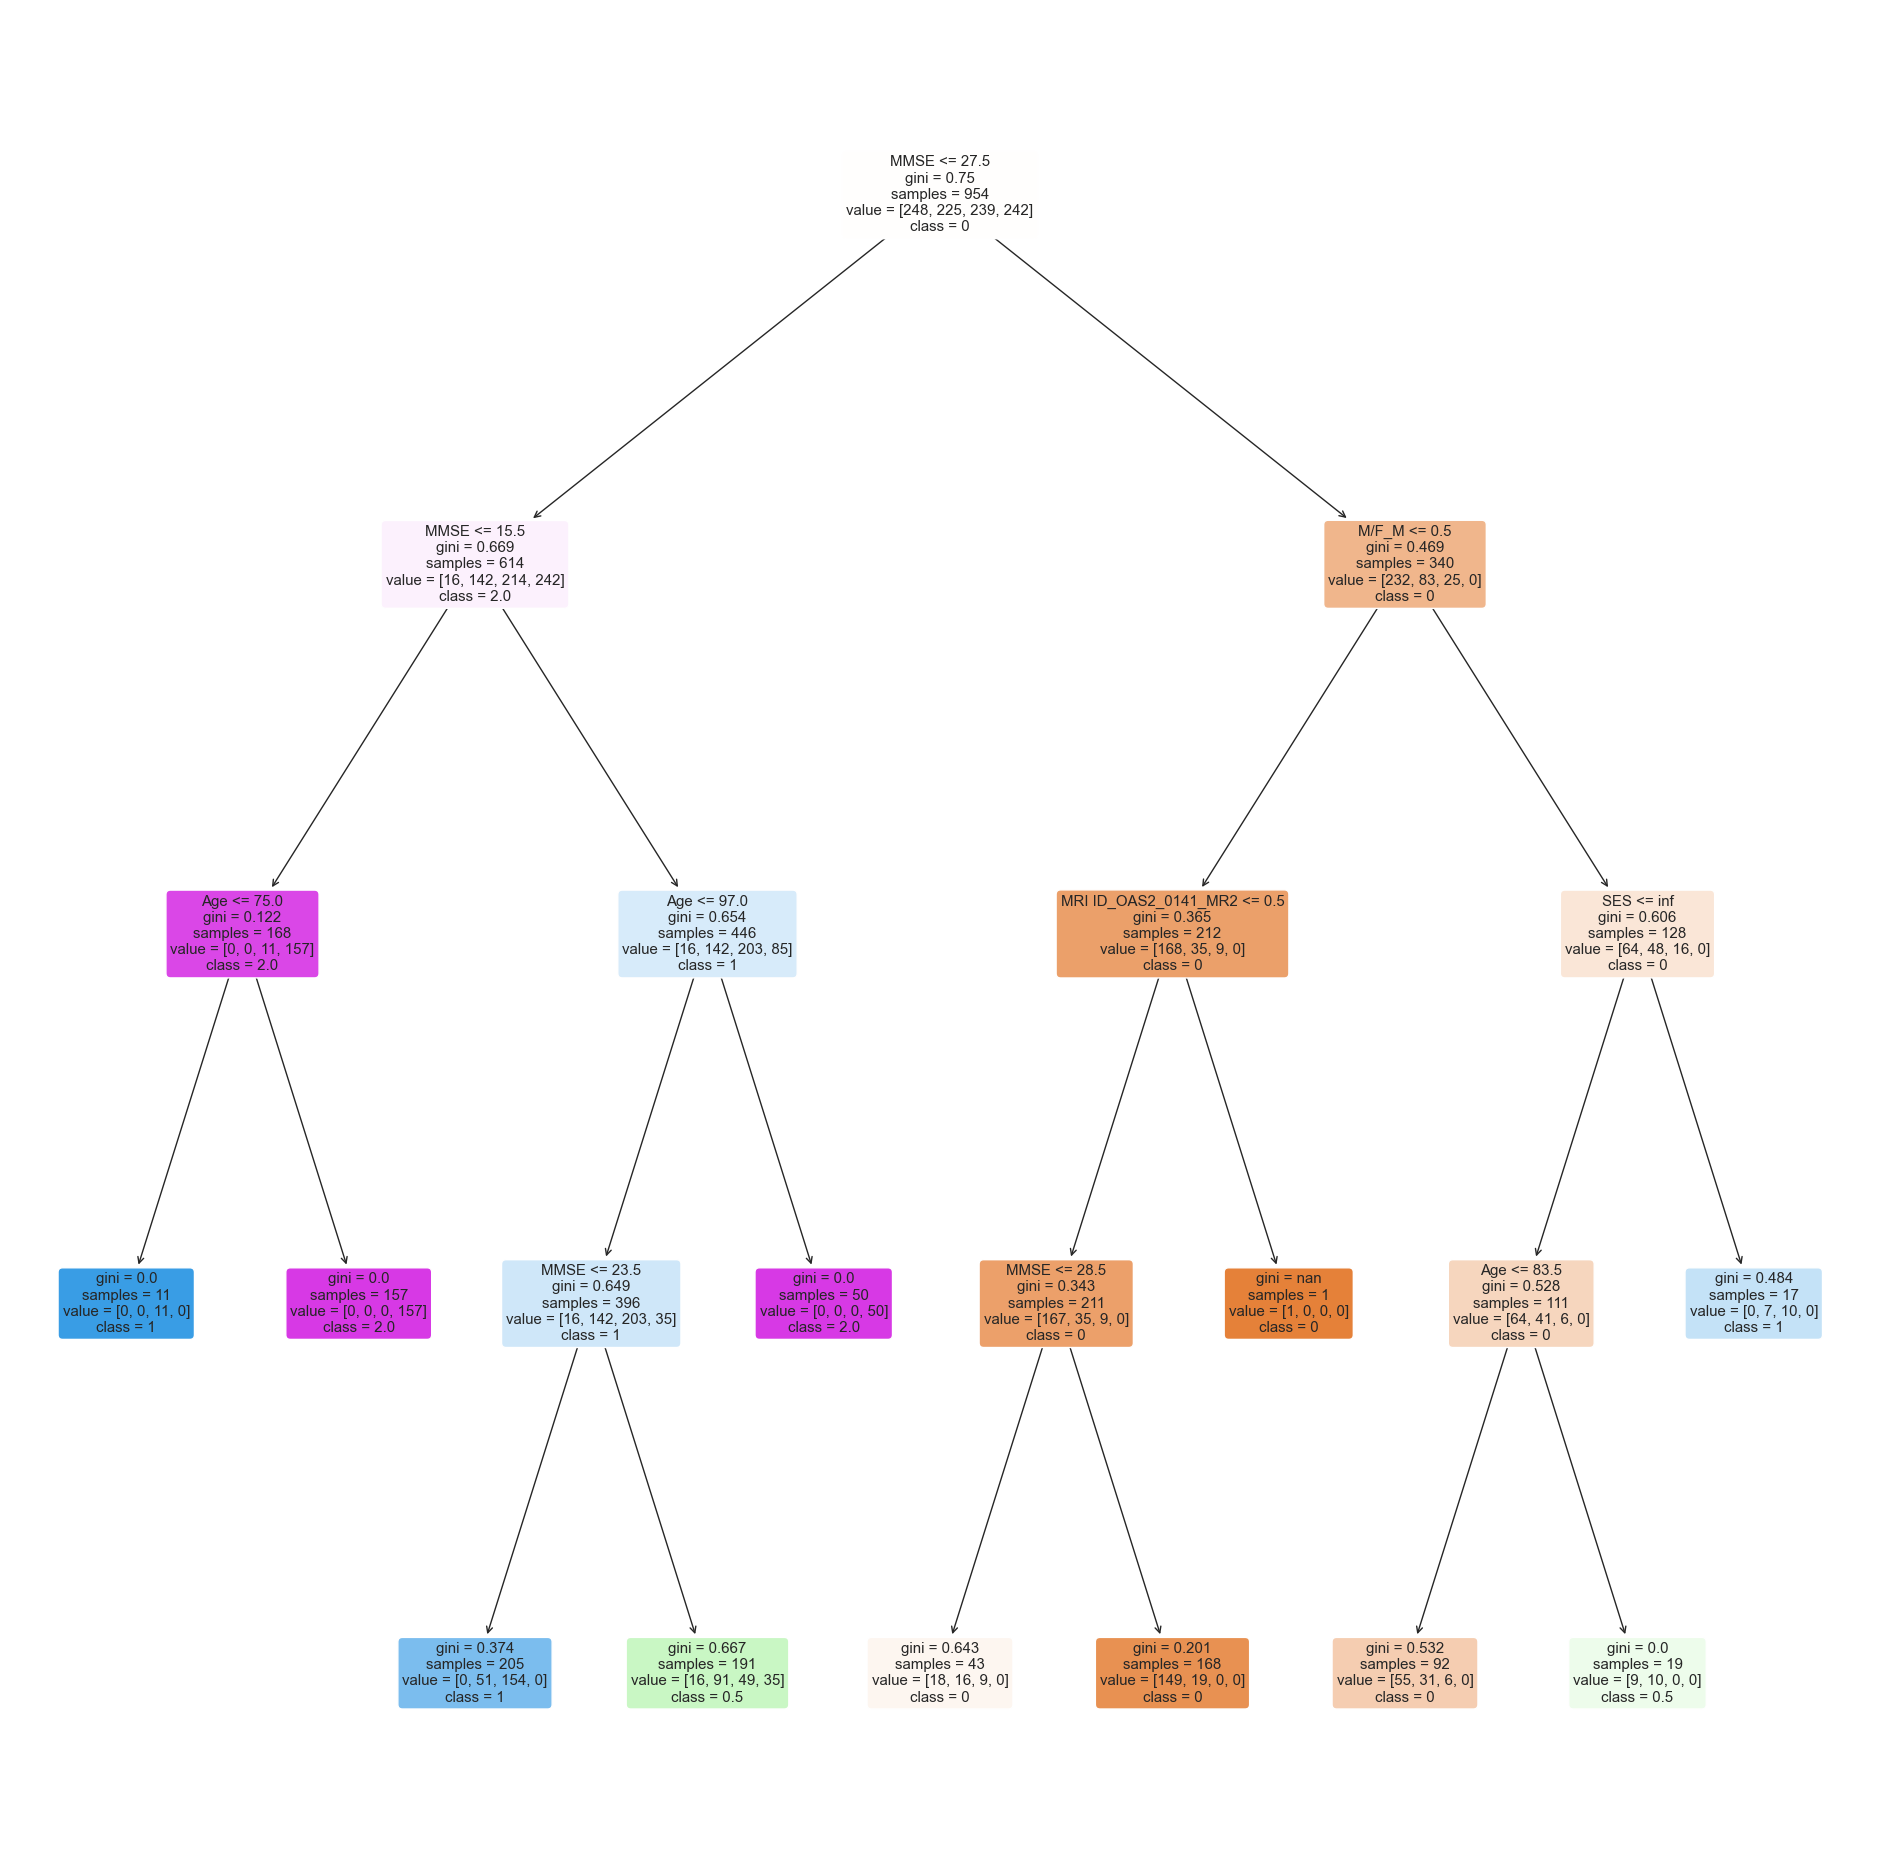

In [18]:
# Convert 'CDR' column to categorical and encode
balanced_alzheimers_data['CDR'] = pd.Categorical(balanced_alzheimers_data['CDR'])
balanced_alzheimers_data['CDR'] = balanced_alzheimers_data['CDR'].cat.codes

# Identify categorical columns (modify this list based on your actual categorical columns)
categorical_cols = balanced_alzheimers_data.select_dtypes(include=['object']).columns.tolist()

# One-hot encode categorical columns
balanced_alzheimers_data = pd.get_dummies(balanced_alzheimers_data, columns=categorical_cols)

# Split the Dataset into Train and Test
X = balanced_alzheimers_data.drop('CDR', axis=1)
y = balanced_alzheimers_data['CDR']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Decision Tree using Train Data
dectree = DecisionTreeClassifier(max_depth=4)
dectree.fit(X_train, y_train)

# Plot the trained Decision Tree
plt.figure(figsize=(24,24))
plot_tree(dectree, filled=True, rounded=True, feature_names=list(X_train.columns), class_names=["0","0.5","1","2.0"])
plt.show()


### Check the accuracy of the Model

Print the Classification Accuracy and all other Accuracy Measures from the Confusion Matrix.  

| Confusion Matrix  |       |        |        |      
| :---              | :---: | :----: | :----: |         
| Actual Negative   |  (0)  |   TN   |   FP   |             
| Actual Positive   |  (1)  |   FN   |   TP   |       
|                   |       |   (0)   |   (1)   |       
|                   |       | Predicted Negative    |   Predicted Postitive  |     


* `TPR = TP / (TP + FN)` : True Positive Rate = True Positives / All Positives    
* `TNR = TN / (TN + FP)` : True Negative Rate = True Negatives / All Negatives    

* `FPR = FP / (TN + FP)` : False Positive Rate = False Positives / All Negatives 
* `FNR = FN / (TP + FN)` : False Negative Rate = False Negatives / All Positives 

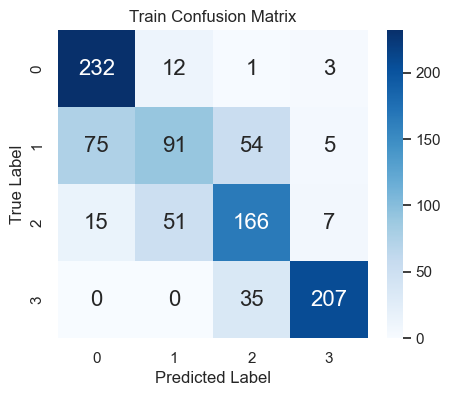

Train Data:
Accuracy: 0.7296
True Positive Rate: 0.5482
True Negative Rate: 0.9508


False Positive Rate: 0.0492
False Negative Rate: 0.4518


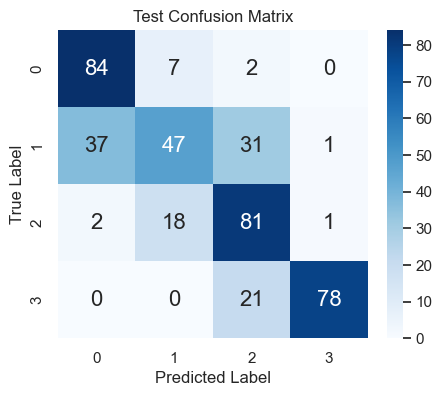

Test Data:
Accuracy: 0.7073
True Positive Rate: 0.5595
True Negative Rate: 0.9231


False Positive Rate: 0.0769
False Negative Rate: 0.4405


In [19]:
from sklearn.metrics import accuracy_score

def print_performance_metrics(y_true, y_pred, dataset_type):
    """ Prints the performance metrics for the provided dataset type (Train/Test). """
    # Confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel() if cm.size == 4 else (cm[0][0], cm[0][1], cm[1][0], cm[1][1])
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    fpr = fp / (tn + fp)
    fnr = fn / (tp + fn)

    # Plotting the confusion matrix
    plt.figure(figsize=(5, 4))
    sb.heatmap(cm, annot=True, fmt="d", cmap='Blues', annot_kws={"size": 16})
    plt.title(f'{dataset_type} Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Printing metrics
    print(f"{dataset_type} Data:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"True Positive Rate: {tpr:.4f}")
    print(f"True Negative Rate: {tnr:.4f}")
    print("\n")
    print(f"False Positive Rate: {fpr:.4f}")
    print(f"False Negative Rate: {fnr:.4f}")

def evaluate_decision_tree():
    # Load and prepare data (assuming balanced_alzheimers_data is preloaded and 'CDR' is coded)
    X = balanced_alzheimers_data.drop('CDR', axis=1)
    y = balanced_alzheimers_data['CDR']

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

    # Train the decision tree model
    dectree = DecisionTreeClassifier(max_depth=4)
    dectree.fit(X_train, y_train)

    # Prediction
    y_train_pred = dectree.predict(X_train)
    y_test_pred = dectree.predict(X_test)

    # Evaluate and print performance metrics for training data
    print_performance_metrics(y_train, y_train_pred, "Train")

    # Evaluate and print performance metrics for testing data
    print_performance_metrics(y_test, y_test_pred, "Test")

# Run the evaluation
evaluate_decision_tree()


The false positives and false negatives are more balanced now. But, there is room for improvement.

---
# CREATING A MODEL FOR `CDR`: Attempt 3

It is quite obvious that the Decision Tree is not doing too well, even after upsampling and encoding. It is time for us to move on to some other classifiers. Let's try another tree based classifier -- `RandomForest`, very close to Decision Tree in principle, but instead of a single tree, it uses an *ensemble* of trees for better classification. It is super-simple to find a new model in `sklearn`, read the documentation a little, and apply it immediately, as follows. Try it out!     

We will keep all the goodness of upsampling and encoding from our previous attempts, and thus, we will use the final dataset we created in the last attempt.

In [20]:
# Extract Response and Predictors
y = pd.DataFrame(balanced_alzheimers_data['CDR'])
X = pd.DataFrame(balanced_alzheimers_data.drop('CDR', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

In [21]:
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier

# Handling missing values in X_train
imputer_X = SimpleImputer(missing_values=np.nan, strategy='mean')  # Replace NaNs with the mean of columns in X_train
X_train_imputed = imputer_X.fit_transform(X_train)

# Handling missing values in y_train.Rating
imputer_y = SimpleImputer(missing_values=np.nan, strategy='most_frequent')  # Replace NaNs with the most frequent values in y_train.Rating
y_train_imputed = imputer_y.fit_transform(y_train[['CDR']]).ravel()  # Ensure it is a 1D array for sklearn

# Creating the RandomForest object
rforest = RandomForestClassifier(n_estimators=100, max_depth=4)

# Fit RandomForest on the preprocessed Train Data
rforest.fit(X_train_imputed, y_train_imputed)


RandomForestClassifier(max_depth=4)

In [82]:
from sklearn.metrics import classification_report

def evaluate_model_performance(X, y, rforest, dataset_name="Train"):
    """
    Evaluates the performance of a trained RandomForest model on a given dataset.
    
    Parameters:
    - X: Features dataset (either X_train or X_test)
    - y: Target dataset (either y_train or y_test)
    - rforest: Trained RandomForest model
    - dataset_name: Label indicating whether the dataset is training or testing set
    """
    # Create an imputer object to fill missing values
    imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
    
    # Impute missing values in X
    X_imputed = imputer.fit_transform(X)
    
    # Predict the responses for the imputed data
    y_pred = rforest.predict(X_imputed)
    
    # Print the classification accuracy
    print(f"{dataset_name} Data")
    print("Accuracy  :\t", accuracy_score(y['CDR'].ravel(), y_pred))
    print()
    
    # Prepare y by ensuring it is correctly shaped for comparison
    y_processed = np.ravel(y[['CDR']])  # Ensure it is a 1D array for sklearn
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_processed, y_pred)
    tp = cm[1][1]  # True Positives
    fp = cm[0][1]  # False Positives
    tn = cm[0][0]  # True Negatives
    fn = cm[1][0]  # False Negatives
    
    # Print accuracy measures derived from the confusion matrix
    print("True Positive Rate (TPR) " + dataset_name + " :\t", (tp / (tp + fn)) if (tp + fn) != 0 else "N/A")
    print("True Negative Rate (TNR) " + dataset_name + " :\t", (tn / (tn + fp)) if (tn + fp) != 0 else "N/A")
    print()
    print("False Positive Rate (FPR) " + dataset_name + " :\t", (fp / (fp + tn)) if (fp + tn) != 0 else "N/A")
    print("False Negative Rate (FNR) " + dataset_name + " :\t", (fn / (fn + tp)) if (fn + tp) != 0 else "N/A")
    
    # Print a detailed classification report
    print("\nDetailed Classification Report:")
    print(classification_report(y_processed, y_pred))
    
    # Plot the two-way confusion matrix
    plt.figure(figsize=(8, 6))
    sb.heatmap(cm, annot=True, fmt=".0f", annot_kws={"size": 18}, cmap='Blues')
    plt.title(f'Confusion Matrix for {dataset_name} Data')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()


Train Data
Accuracy  :	 0.8050314465408805

True Positive Rate (TPR) Train :	 0.6470588235294118
True Negative Rate (TNR) Train :	 0.9612068965517241

False Positive Rate (FPR) Train :	 0.03879310344827586
False Negative Rate (FNR) Train :	 0.35294117647058826

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.95      0.82       234
           1       0.79      0.55      0.65       242
           2       0.85      0.72      0.78       234
           3       0.87      1.00      0.93       244

    accuracy                           0.81       954
   macro avg       0.81      0.81      0.80       954
weighted avg       0.81      0.81      0.80       954



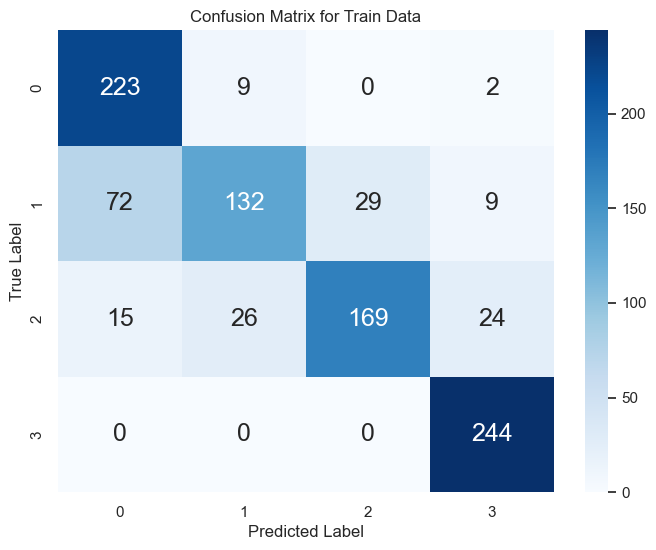

In [23]:
evaluate_model_performance(X_train, y_train, rforest, "Train")

Test Data
Accuracy  :	 0.7317073170731707

True Positive Rate (TPR) Test :	 0.42857142857142855
True Negative Rate (TNR) Test :	 0.9252336448598131

False Positive Rate (FPR) Test :	 0.07476635514018691
False Negative Rate (FNR) Test :	 0.5714285714285714

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.93      0.76       107
           1       0.57      0.33      0.42        99
           2       0.86      0.66      0.75       107
           3       0.84      1.00      0.92        97

    accuracy                           0.73       410
   macro avg       0.73      0.73      0.71       410
weighted avg       0.73      0.73      0.71       410



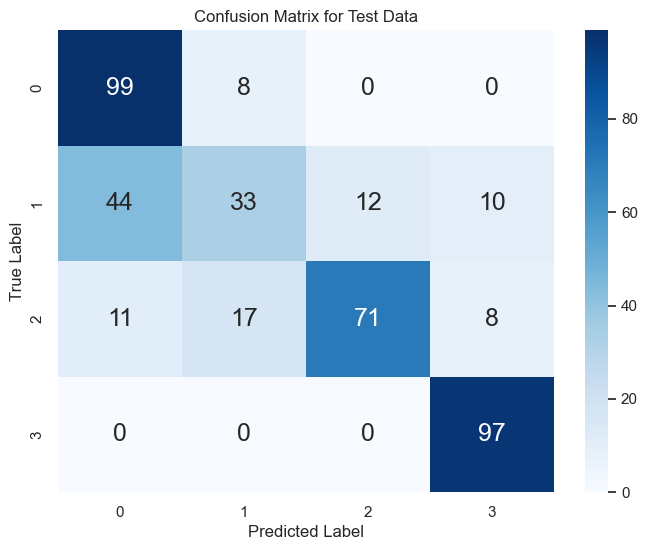

In [24]:
evaluate_model_performance(X_test, y_test, rforest, "Test")

### Increase the Number of Decision Trees in the Forest

In [25]:
# Extract Response and Predictors
y = pd.DataFrame(balanced_alzheimers_data['CDR'])
X = pd.DataFrame(balanced_alzheimers_data.drop('CDR', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Handling missing values in X_train
imputer_X = SimpleImputer(missing_values=np.nan, strategy='mean')  # Replace NaNs with the mean of columns in X_train
X_train_imputed = imputer_X.fit_transform(X_train)

# Handling missing values in y_train.Rating
imputer_y = SimpleImputer(missing_values=np.nan, strategy='most_frequent')  # Replace NaNs with the most frequent values in y_train.Rating
y_train_imputed = imputer_y.fit_transform(y_train[['CDR']]).ravel()  # Ensure it is a 1D array for sklearn

# Creating the RandomForest object
rforest = RandomForestClassifier(n_estimators=1000, max_depth=4) #changed to 1000 

# Fit RandomForest on the preprocessed Train Data
rforest.fit(X_train_imputed, y_train_imputed)


RandomForestClassifier(max_depth=4, n_estimators=1000)

Train Data Accuracy: 0.9486

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       244
           1       0.97      0.82      0.89       233
           2       0.95      1.00      0.97       246
           3       1.00      1.00      1.00       231

    accuracy                           0.95       954
   macro avg       0.95      0.95      0.95       954
weighted avg       0.95      0.95      0.95       954



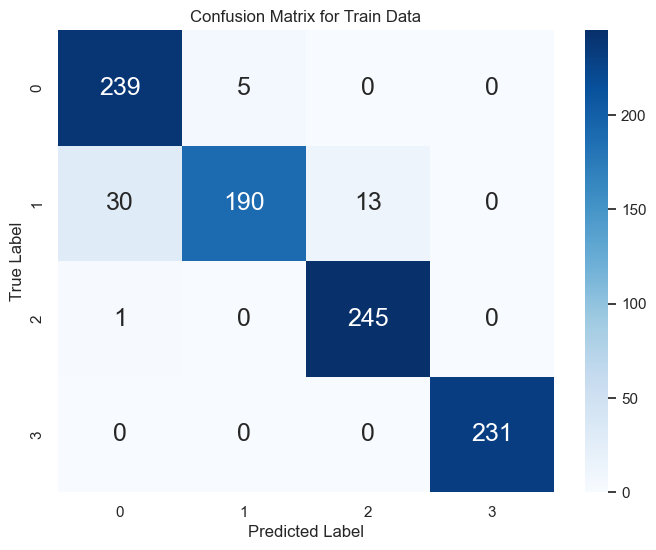

In [81]:
evaluate_model_performance(X_train, y_train, rforest, "Train")

Test Data
Accuracy  :	 0.7

True Positive Rate (TPR) Test :	 0.4939759036144578
True Negative Rate (TNR) Test :	 0.9545454545454546

False Positive Rate (FPR) Test :	 0.045454545454545456
False Negative Rate (FNR) Test :	 0.5060240963855421

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.94      0.73        89
           1       0.58      0.42      0.49        98
           2       0.88      0.50      0.63       121
           3       0.79      1.00      0.88       102

    accuracy                           0.70       410
   macro avg       0.71      0.71      0.68       410
weighted avg       0.72      0.70      0.68       410



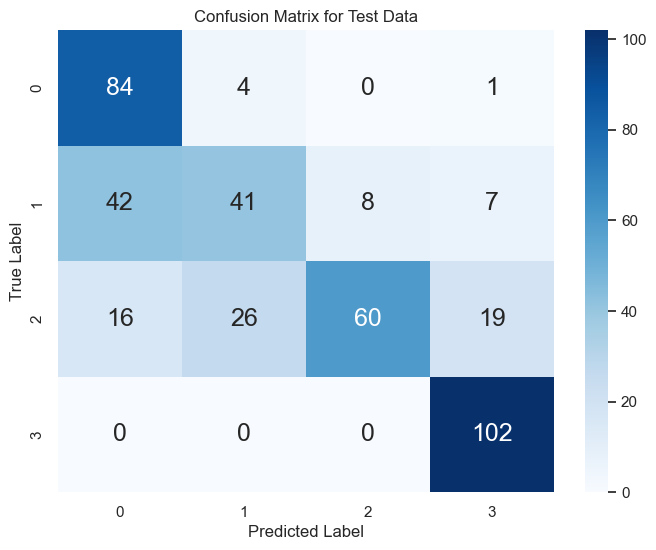

In [27]:
evaluate_model_performance(X_test, y_test, rforest, "Test")

### Increase the Depth of Decision Trees in the Forest

In [28]:
# Extract Response and Predictors
y = pd.DataFrame(balanced_alzheimers_data['CDR'])
X = pd.DataFrame(balanced_alzheimers_data.drop('CDR', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Handling missing values in X_train
imputer_X = SimpleImputer(missing_values=np.nan, strategy='mean')  # Replace NaNs with the mean of columns in X_train
X_train_imputed = imputer_X.fit_transform(X_train)

# Handling missing values in y_train.Rating
imputer_y = SimpleImputer(missing_values=np.nan, strategy='most_frequent')  # Replace NaNs with the most frequent values in y_train.Rating
y_train_imputed = imputer_y.fit_transform(y_train[['CDR']]).ravel()  # Ensure it is a 1D array for sklearn

# Creating the RandomForest object
rforest = RandomForestClassifier(n_estimators=100, max_depth=10) #changed to 10 (depth) 

# Fit RandomForest on the preprocessed Train Data
rforest.fit(X_train_imputed, y_train_imputed)


RandomForestClassifier(max_depth=10)

Train Data
Accuracy  :	 0.940251572327044

True Positive Rate (TPR) Train :	 0.8058252427184466
True Negative Rate (TNR) Train :	 0.9957805907172996

False Positive Rate (FPR) Train :	 0.004219409282700422
False Negative Rate (FNR) Train :	 0.1941747572815534

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92       237
           1       0.99      0.75      0.85       221
           2       0.94      1.00      0.97       250
           3       1.00      1.00      1.00       246

    accuracy                           0.94       954
   macro avg       0.95      0.94      0.94       954
weighted avg       0.95      0.94      0.94       954



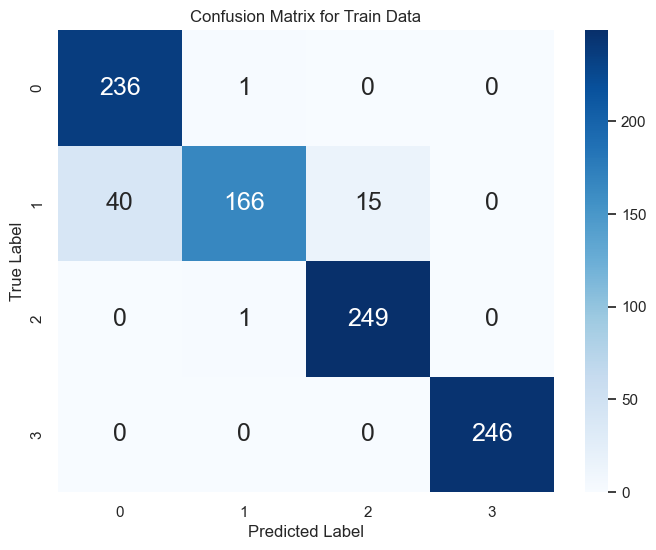

In [29]:
evaluate_model_performance(X_train, y_train, rforest, "Train")

Test Data
Accuracy  :	 0.8658536585365854

True Positive Rate (TPR) Test :	 0.6160714285714286
True Negative Rate (TNR) Test :	 0.9711538461538461

False Positive Rate (FPR) Test :	 0.028846153846153848
False Negative Rate (FNR) Test :	 0.38392857142857145

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.70      0.97      0.81       104
           1       0.95      0.57      0.72       120
           2       0.92      0.99      0.95        91
           3       1.00      1.00      1.00        95

    accuracy                           0.87       410
   macro avg       0.89      0.88      0.87       410
weighted avg       0.89      0.87      0.86       410



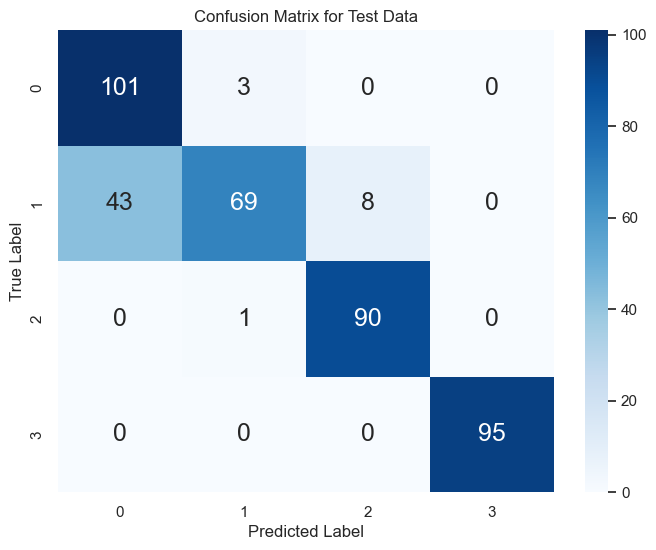

In [30]:
evaluate_model_performance(X_test, y_test, rforest, "Test")

### Increase both Number and Depth of Decision Trees in the Forest

In [52]:
# Extract Response and Predictors
y = pd.DataFrame(balanced_alzheimers_data['CDR'])
X = pd.DataFrame(balanced_alzheimers_data.drop('CDR', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)


# Handling missing values in X_train
imputer_X = SimpleImputer(missing_values=np.nan, strategy='mean')  # Replace NaNs with the mean of columns in X_train
X_train_imputed = imputer_X.fit_transform(X_train)

# Handling missing values in y_train.Rating
imputer_y = SimpleImputer(missing_values=np.nan, strategy='most_frequent')  # Replace NaNs with the most frequent values in y_train.Rating
y_train_imputed = imputer_y.fit_transform(y_train[['CDR']]).ravel()  # Ensure it is a 1D array for sklearn

# Creating the RandomForest object
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10) #changed to 100 and 10

# Fit RandomForest on the preprocessed Train Data
rforest.fit(X_train_imputed, y_train_imputed)


RandomForestClassifier(max_depth=10, n_estimators=1000)

Train Data
Accuracy  :	 0.9276729559748428

True Positive Rate (TPR) Train :	 0.8169014084507042
True Negative Rate (TNR) Train :	 0.976

False Positive Rate (FPR) Train :	 0.024
False Negative Rate (FNR) Train :	 0.18309859154929578

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91       251
           1       0.96      0.75      0.84       232
           2       0.92      0.98      0.95       237
           3       1.00      1.00      1.00       234

    accuracy                           0.93       954
   macro avg       0.93      0.93      0.93       954
weighted avg       0.93      0.93      0.93       954



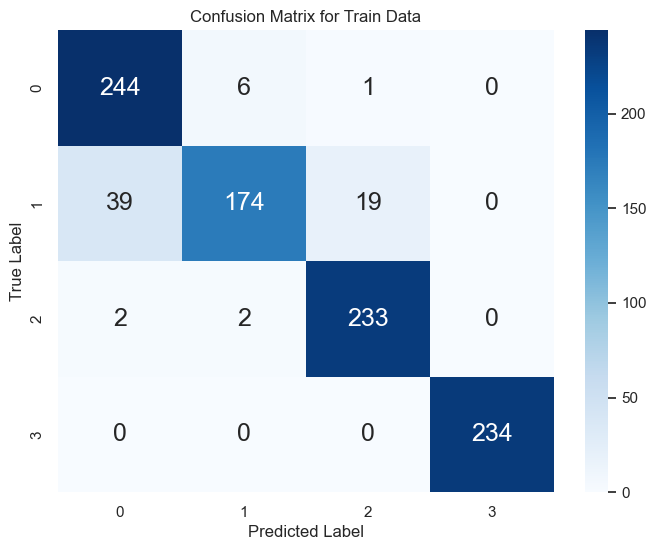

In [53]:
evaluate_model_performance(X_train, y_train, rforest, "Train")

Test Data
Accuracy  :	 0.8731707317073171

True Positive Rate (TPR) Test :	 0.631578947368421
True Negative Rate (TNR) Test :	 0.9777777777777777

False Positive Rate (FPR) Test :	 0.022222222222222223
False Negative Rate (FNR) Test :	 0.3684210526315789

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.98      0.82        90
           1       0.97      0.55      0.70       109
           2       0.88      0.99      0.93       104
           3       1.00      1.00      1.00       107

    accuracy                           0.87       410
   macro avg       0.89      0.88      0.86       410
weighted avg       0.90      0.87      0.86       410



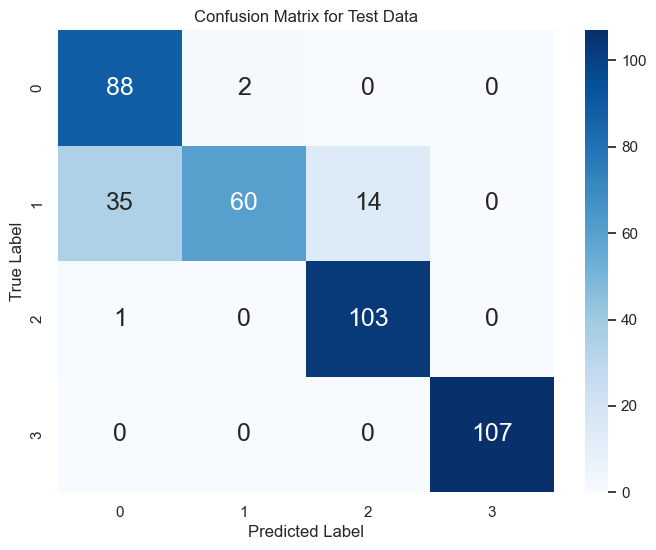

In [54]:
evaluate_model_performance(X_test, y_test, rforest, "Test")

Note that with more number of trees and deeper trees in the forest, the accuracy of the Random Forest is getting better on both the train and test sets, but the gap between the performance on train and test is increasing too. This may be an indication of overfitting the train set. Read up more about over-fitting.      

Now we will need to find the optimal hyper-parameters to maximize accuracy of the classifier on the test set in general. We are only trying out a single `train_test_split`, and it is impossible to predict the *generalized* performance of the model from a single run. Thus, we will need to run this multiple times, with randomized train and test sets, to get a better estimate. Both of these targets are achieved through Cross-Validation techniques, whereby you can optimize the hyper-parameters of a model. There are several tools available to perform Cross-Validation and Tune Hyper-parameters of a model.

---
# CREATING A MODEL FOR `CDR`: Attempt 4

Basic set of tools for Cross-Validation to tune the Hyper-parameters of Random Forest in this case.

In [38]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Prepare response (y) and predictors (X)
y = pd.DataFrame(balanced_alzheimers_data['CDR'])
X = pd.DataFrame(balanced_alzheimers_data.drop('CDR', axis=1))

# Split the data
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)

# Impute missing values
imputer = SimpleImputer(strategy='median')
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Define a smaller hyperparameter grid
param_grid = {
    'n_estimators': np.arange(100,1001,100),  # fewer options
    'max_depth': np.arange(2, 11)
}

# Use RandomizedSearchCV to reduce the number of iterations
hpGrid = RandomizedSearchCV(
    estimator=RandomForestClassifier(),
    param_distributions=param_grid,
    n_iter=5,  # number of parameter settings sampled
    cv=3,  # fewer folds
    scoring='accuracy',
    n_jobs=-1  # use all CPU cores
)

# Train models using cross-validation
hpGrid.fit(X_train_imputed, y_train.values.ravel())

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=5,
                   n_jobs=-1,
                   param_distributions={'max_depth': array([ 2,  3,  4,  5,  6,  7,  8,  9, 10]),
                                        'n_estimators': array([ 100,  200,  300,  400,  500,  600,  700,  800,  900, 1000])},
                   scoring='accuracy')

By using randomized search CV will help in systematically test out different combinations of parametrs to find the bst fit based on model performance metrics such as 'accuracy'

In [40]:
# Fetch the best Model or the best set of Hyper-parameters
print(hpGrid.best_estimator_)

# Print the score (accuracy) of the best Model after CV
print(np.abs(hpGrid.best_score_))

RandomForestClassifier(max_depth=10, n_estimators=600)
0.8668763102725366


In [39]:
# Output the best model parameters and its accuracy
print("Best Parameters:", hpGrid.best_params_)
print("Best Model:", hpGrid.best_estimator_)

Best Parameters: {'n_estimators': 600, 'max_depth': 10}
Best Model: RandomForestClassifier(max_depth=10, n_estimators=600)


### Use the Best Model found through GridSearchCV

In [56]:
# Extract Response and Predictors
y = pd.DataFrame(balanced_alzheimers_data['CDR'])
X = pd.DataFrame(balanced_alzheimers_data.drop('CDR', axis = 1))

# Split the Dataset into Train and Test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

# Create an imputer object with a median filling strategy
imputer = SimpleImputer(strategy='median')

# Fit on the training data and transform it
X_train_imputed = imputer.fit_transform(X_train)
X_test_imputed = imputer.transform(X_test)

# Create the Random Forest object with the optimal parameters
rforest = RandomForestClassifier(n_estimators = 600, max_depth = 10)

# Fit Random Forest on the imputed Train Data
rforest.fit(X_train_imputed, y_train.CDR.ravel())


RandomForestClassifier(max_depth=10, n_estimators=600)

Train Data
Accuracy  :	 0.9486373165618449

True Positive Rate (TPR) Train :	 0.8636363636363636
True Negative Rate (TNR) Train :	 0.9795081967213115

False Positive Rate (FPR) Train :	 0.020491803278688523
False Negative Rate (FNR) Train :	 0.13636363636363635

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.98      0.93       244
           1       0.97      0.82      0.89       233
           2       0.95      1.00      0.97       246
           3       1.00      1.00      1.00       231

    accuracy                           0.95       954
   macro avg       0.95      0.95      0.95       954
weighted avg       0.95      0.95      0.95       954



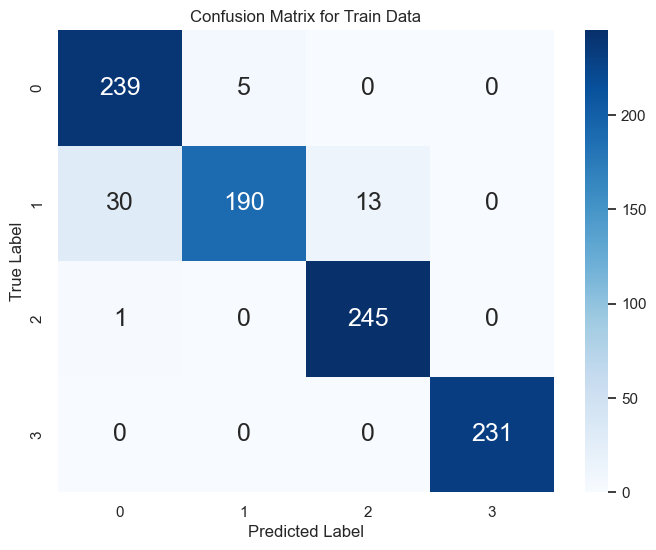

In [57]:
evaluate_model_performance(X_train, y_train, rforest, "Train")

Test Data
Accuracy  :	 0.8634146341463415

True Positive Rate (TPR) Test :	 0.6701030927835051
True Negative Rate (TNR) Test :	 0.9375

False Positive Rate (FPR) Test :	 0.0625
False Negative Rate (FNR) Test :	 0.32989690721649484

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.93      0.81        97
           1       0.87      0.60      0.71       108
           2       0.88      0.94      0.91        95
           3       1.00      1.00      1.00       110

    accuracy                           0.86       410
   macro avg       0.87      0.87      0.86       410
weighted avg       0.87      0.86      0.86       410



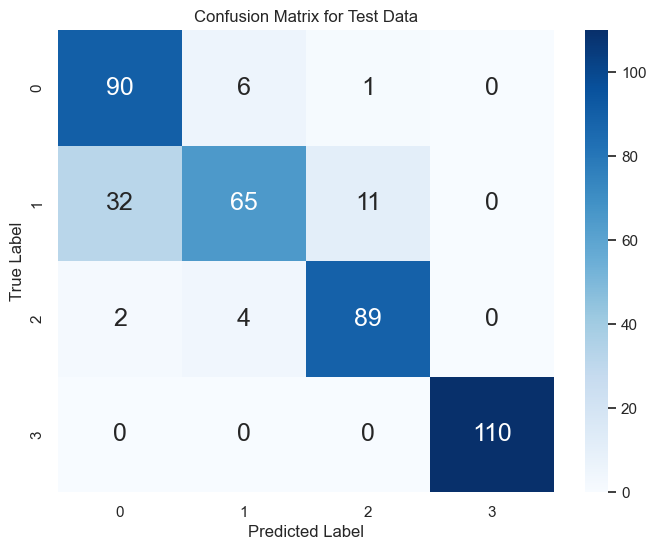

In [58]:
evaluate_model_performance(X_test, y_test, rforest, "Test")